In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as intpol
from scipy.optimize import curve_fit
import numpy as np
from blackbody import *
from mag_flux_convert import *

wavelength = {'UVW2':1928., 'UVM2':2246., 'UVW1':2600., 'U':3465., 'B':4392., 'V':5468., 'R':6442., 'I':7994., 
       'J':12200., 'H':16458., 'KS':21603.}
col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}

In [2]:
def get_mag_interpol(mag_intpol, day):
    """return x = numpy.array of wavelength, y = numpy.array of intpolated magnitude, z = numpy.array of band
    mag_intpol = dict of scipy.interpolate.interp1d with keys as bands
    day = one number representing day for interpolation
    wavelength = dict of wavelength with keys as bands, pre-defined"""
    x = []
    y = []
    z = []
    for i in mag_intpol.keys():
        if np.isnan(mag_intpol[i](day).tolist()):
            continue
        x.append(wavelength[i])
        y.append(mag_intpol[i](day).tolist())
        z.append(i)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x, y, z

In [3]:
# load
sn = pd.read_csv(r"D:\Unknown 3rd project\2009ip\Default\python\01_01_sn2009ip_clean.dat")

In [4]:
# subset 56000--56600
dat = sn.query('MJD>=56000 & MJD<=56600')
dat.head()

,MJD,Vegamag,emag,band
4,56147.23,18.51,0.01,B
5,56147.23,18.12,0.05,I
6,56147.23,18.22,0.03,R
7,56147.23,17.54,0.01,U
8,56147.23,18.43,0.04,V


In [5]:
# interpolate for each band
mag_intpol = {}
for i in dat['band'].unique():
    mag_intpol[i] = intpol.interp1d(
        dat['MJD'].where(dat['band'] == i).dropna(), 
        dat['Vegamag'].where(dat['band'] == i).dropna(), 
        fill_value=None, bounds_error=False)

In [6]:
# fit BB : UVW2--UVW1 + B--I
z = np.arange(56000, 56600, step=1)
# band_UV = set(['UVW2', 'UVM2', 'UVW1'])
band_opt = set(['V', 'R', 'I'])
# MJD2_UV = []
MJD2_opt = []
# param2_UV = []
param2_opt = []
# paramcov2_UV = []
paramcov2_opt = []
for j in z:
    x, y, a = get_mag_interpol(mag_intpol, j)
#     x_UV = []
#     y_UV = []
    x_opt = []
    y_opt = []
    for i in a:
#         if i in band_UV:
#             x_UV.append(wavelength[i])
#             y_UV.append(y[np.where(a == i)].tolist()[0])
        if i in band_opt:
            x_opt.append(wavelength[i])
            y_opt.append(y[np.where(a == i)].tolist()[0])
    
#     x_UV = np.array(x_UV)
#     y_UV = np.array(y_UV)
    x_opt = np.array(x_opt)
    y_opt = np.array(y_opt)
#     if x_UV.size >= 2:
#         popt, pcov = curve_fit(bb_lambda_mag, x_UV, y_UV, p0=[5000., -20.])
#         MJD2_UV.append(j)
#         param2_UV.append(popt)
#         paramcov2_UV.append(pcov)
    if x_opt.size >=2:
        popt, pcov = curve_fit(bb_lambda_mag, x_opt, y_opt, p0=[5000., -20.])
        MJD2_opt.append(j)
        param2_opt.append(popt)
        paramcov2_opt.append(pcov)        
                
# MJD2_UV = np.array(MJD2_UV)
# param2_UV = np.array(param2_UV)
# paramcov2_UV = np.array(paramcov2_UV)
MJD2_opt = np.array(MJD2_opt)
param2_opt = np.array(param2_opt)
paramcov2_opt = np.array(paramcov2_opt)

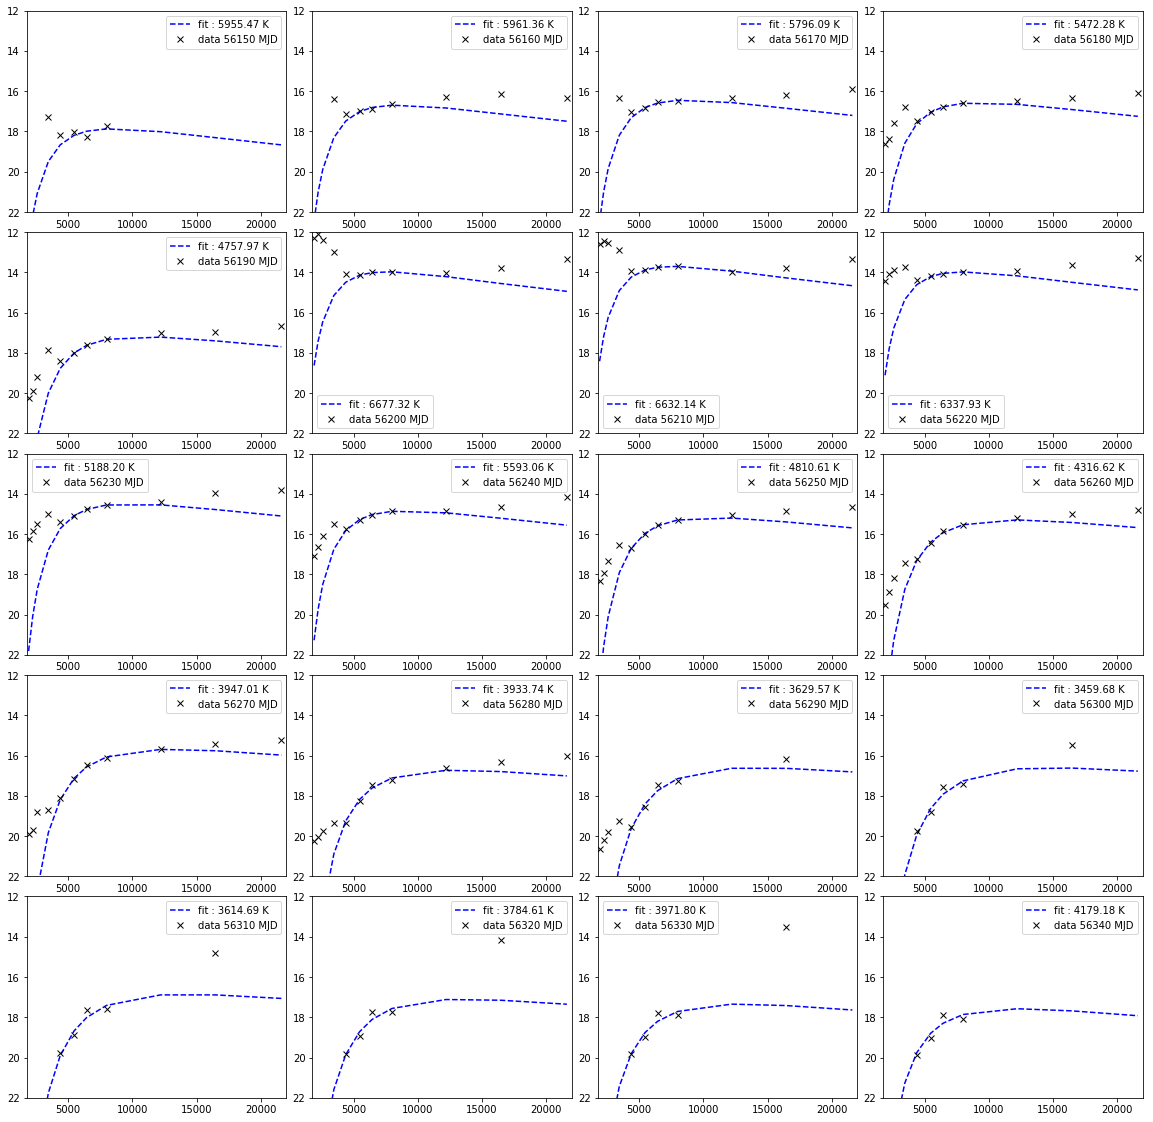

In [7]:
# plot SEDs
z = np.arange(56150, 56350, step=10)
ncol = 4
nrow = int(z.size / ncol)
fig, AX = plt.subplots(nrow, ncol, sharex=False, sharey=False, figsize=(20,5*ncol))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

j = 0
for ax in AX.flatten():
#     index = np.array(np.where(MJD == z[j]))
#     if index.size == 0:
#         j += 1 
#         continue
#     x = np.fromiter(wavelength.values(), dtype=float)
#     y = get_bb_mag(x, param[index,0], param[index,1])
#     o = x.argsort()
#     ax.plot(x[o], y[o], 'k-', label='fit : ' + '{:.2f}'.format(param[index,0][0,0]) + ' K') 
#     ax.set_ylim(12,20)
    
#     if (z[j] in MJD2_UV):
#         index = np.array(np.where(MJD2_UV == z[j]))
#         x = np.fromiter(wavelength.values(), dtype=float)
#         yuv = get_bb_mag(x, param2_UV[index,0], param2_UV[index,1])
#         o = x.argsort()
#         ax.plot(x[o], yuv[o], 'm--', label='fit : ' + '{:.2f}'.format(param2_UV[index,0][0,0]) + ' K')
    
    if (z[j] in MJD2_opt):
        index = np.array(np.where(MJD2_opt == z[j]))
        x = np.fromiter(wavelength.values(), dtype=float)
        yopt = get_bb_mag(x, param2_opt[index,0][0][0], param2_opt[index,1][0][0])
        o = x.argsort()
        ax.plot(x[o], yopt[o], 'b--', label='fit : ' + '{:.2f}'.format(param2_opt[index,0][0,0]) + ' K')
        
#     if (z[j] in MJD2_UV & z[j] in MJD2_UV):
#         ytot = flux2mag(mag2flux(yopt, x) + mag2flux(yuv, x), x)
#         o = x.argsort()
#         ax.plot(x[o], ytot[o], 'g-', label='fit : UV + Opt')
  
    x, y, a = get_mag_interpol(mag_intpol, z[j])
    o = x.argsort()
    ax.plot(x[o], y[o], 'kx', label='data ' + '{}'.format(z[j]) + ' MJD')
    
    ax.set_ylim(12, 22)
    ax.set_xlim(1800, 22000)
    ax.invert_yaxis()
    ax.legend()
    
    j += 1
    
plt.show()

In [8]:
# opticl subtraction
z = np.arange(56175, 56295, step=1)
band_UV = ['UVW2', 'UVM2', 'UVW1', 'U']
band_opt = ['V', 'R', 'I']
MJD_UV_sub = []
x_UV_sub = []
y_UV_sub = []
for j in z:
    x, y, a = get_mag_interpol(mag_intpol, j)
    x_data_UV = []
    y_data_UV = []
    for i in band_UV:
        index = np.where(x == wavelength[i])
        if np.array(index).size == 0:
            continue
        x_data_UV.append(x[index].tolist()[0])
        y_data_UV.append(y[index].tolist()[0])
    x_data_UV = np.array(x_data_UV)
    y_data_UV = np.array(y_data_UV)

    index = np.where(MJD2_opt == j)
    y_UV_fromOpt = get_bb_mag(x_data_UV, param2_opt[index,0][0][0], param2_opt[index,1][0][0])
    
    y = mag2flux(y_data_UV, ABwave=x_data_UV) - mag2flux(y_UV_fromOpt, ABwave=x_data_UV)
    
    y_UV_sub.append(y)
    x_UV_sub.append(x_data_UV)
    MJD_UV_sub.append(j)
    
y_UV_sub = np.array(y_UV_sub)
x_UV_sub = np.array(x_UV_sub)
MJD_UV_sub = np.array(MJD_UV_sub)

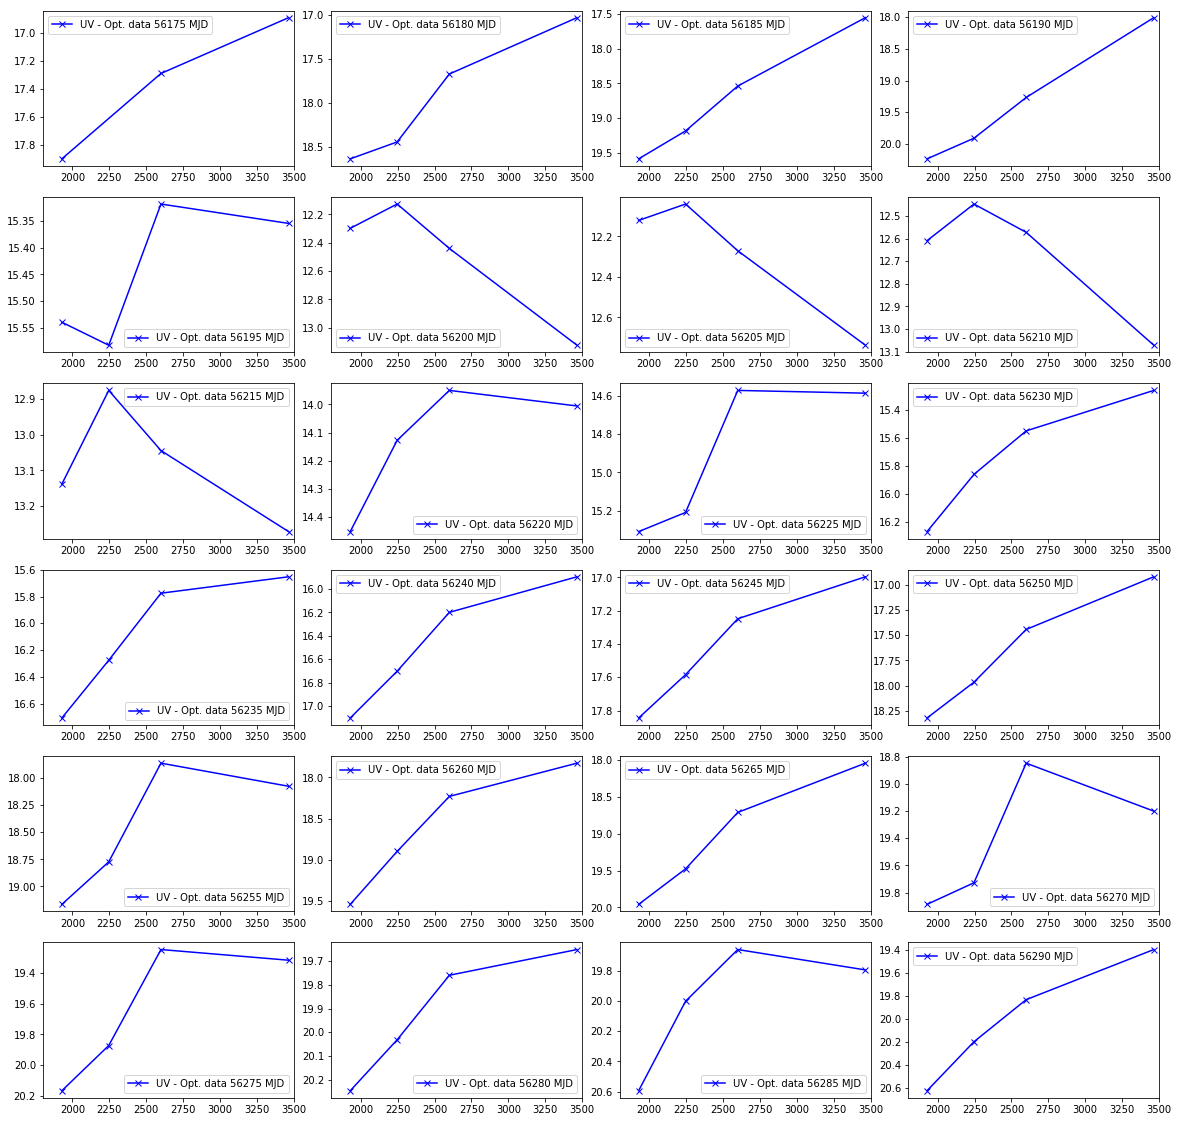

In [9]:
# plot UV sub
ncol = 4
stepsize = 5
nrow = int(MJD_UV_sub.size / ncol / stepsize)
if nrow == 0:
    nrow = 1
fig, AX = plt.subplots(nrow, ncol, sharex=False, sharey=False, figsize=(20,5*ncol))
fig.subplots_adjust(hspace=0.2, wspace=0.15)

j = 0
for ax in AX.flatten():
    o = x_UV_sub[j].argsort()
    ax.plot(x_UV_sub[j][o], flux2mag(y_UV_sub[j][o], ABwave=x_UV_sub[j][o]), 'bx-', label='UV - Opt. data ' + 
            '{}'.format(MJD_UV_sub[j]) + ' MJD')
    
#     ax.set_ylim(1e-16, 1e-12)
    ax.set_xlim(1800, 3500)
#     ax.set_yscale('log')
    ax.invert_yaxis()
    ax.legend()
    
    j += 5
    if j >= MJD_UV_sub.size:
        break
    
plt.show()